In [1]:
path_train = r"E:\pythonDeme\2019-Kaggle-MoviePredict\train.csv"
path_test = r"E:\pythonDeme\2019-Kaggle-MoviePredict\test.csv"

In [81]:
#导入相关库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from wordcloud import WordCloud
from dateutil.parser import parse
import warnings
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

In [3]:
#设置jupyter可以多行输出
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

#jupyter绘图魔术方法
%matplotlib notebook

#忽略警告
warnings.filterwarnings("ignore")

In [11]:
#读取数据
train_data = pd.read_csv(path_train)
test_data = pd.read_csv(path_test)

In [12]:
#查看对象尺度
train_data.shape
test_data.shape

(3000, 23)

(4398, 22)

In [6]:
#训练集总览
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

id:电影的唯一id
belongs_to_collection:这个电影系列的系列名称（不是系列电影就是空值）/TMDB上的ID/海报和背景图链接，json格式
budget:电影的预算，0代表未知
genres:电影的类型以及类型对应的TMDB上的ID，使用json格式封装信息
homepage:电影官方主页
imdb_id：电影在TMDB的ID
orginal_language：电影的原始语言
orginal_title：电影的原始名称
overview：简短的描述
popularity：电影的流行程度，使用浮点数代表
poster_path：电影海报链接
production_copanies：电影的出品公司，使用json格式
production_countries: 电影出品公司所在国家，使用json格式
release_date：发行时间
runtime：电影时长
spoken_languages：电影语言，json格式
status：电影的状态，是否已经发布
tagline：电影的宣传标语
title：电影英文名
keywords：电影的关键词以及相应关键词在TMDB上的ID
cast：演员的姓名/id/性别，使用json格式
crew：职员（导演/编辑/摄影...）的姓名/id/性别，使用json格式
revenue：电影总收入

In [13]:
#训练集和测试集的空值一览
train_data.isna().sum()
test_data.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

In [14]:
train_data[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [15]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else eval(x) )
    return df
        
train_data = text_to_dict(train_data)
test_data = text_to_dict(test_data)
train_data[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [16]:
train_data['belongs_to_collection'].map(lambda x:len(x) if x!='{}' else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [17]:
#训练集处理
train_data['has_collection'] = train_data['belongs_to_collection'].map(lambda x:1 if x!={} else 0)

#测试集处理
test_data['has_collection'] = test_data['belongs_to_collection'].map(lambda x:1 if x!={} else 0)

<IPython.core.display.Javascript object>


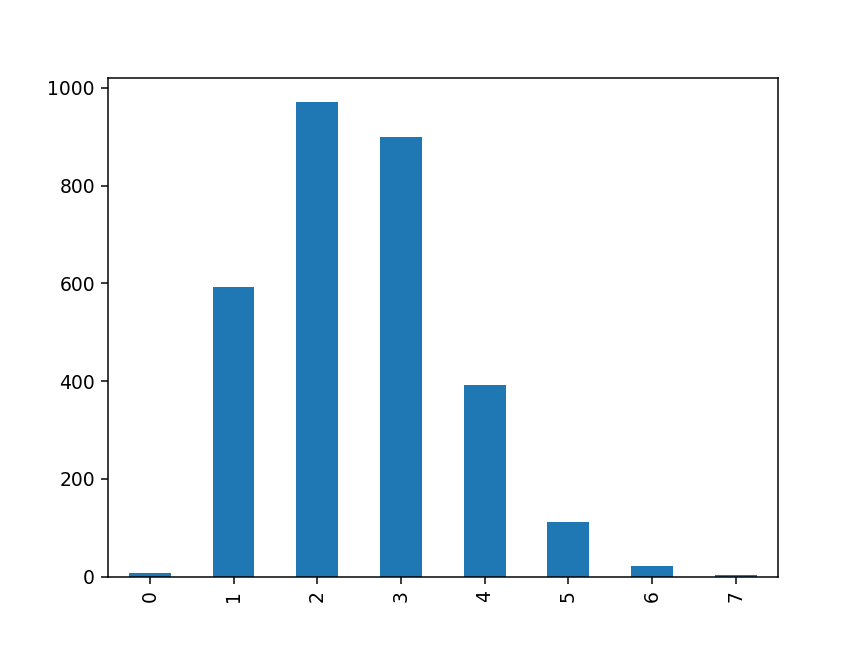

In [19]:
(train_data['genres'].map(lambda x:len(x) if x!={} else 0).value_counts().sort_index()).plot(kind='bar')

In [20]:
#训练集处理
train_data['genres_num'] = train_data['genres'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['genres_num'] = test_data['genres'].map(lambda x:len(x) if x!={} else 0)

In [21]:
#训练集处理
train_data['genres_all'] = train_data['genres'].map(lambda x:','.join([i['name'] for i in x]))

#测试集处理
test_data['genres_all'] = test_data['genres'].map(lambda x:','.join([i['name'] for i in x]))

In [22]:
list_genres = list(train_data['genres'].map(lambda x:[i['name'] for i in x]))
list_genres[:3]
list_genres_count = []
for i in list_genres:
    for j in i:
        list_genres_count.append(j)

[['Comedy'], ['Comedy', 'Drama', 'Family', 'Romance'], ['Drama']]

<IPython.core.display.Javascript object>


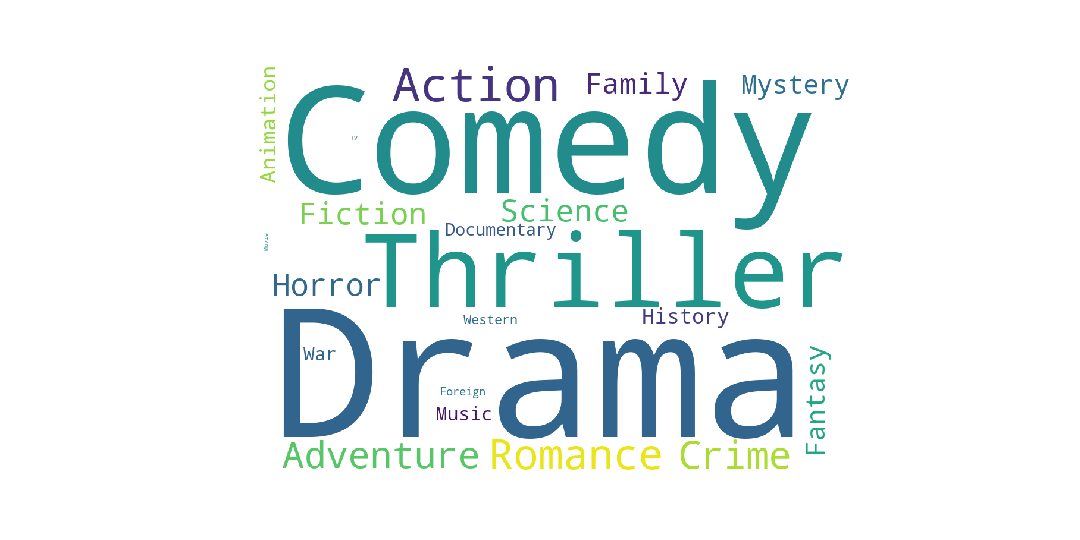

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

In [24]:
#%matplotlib notebook
fig,ax=plt.subplots(figsize=(8,4))
w = WordCloud( 
    width = 1000, height = 700,
    background_color = "white",
    collocations=False
    ).generate(','.join(list_genres_count))
plt.imshow(w)
plt.xticks([])
plt.yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [25]:
genres_top = Counter(list_genres_count).most_common()

In [27]:
list_genres_count = Counter(list_genres_count)
list_genres_count = list(list_genres_count)
len(list_genres_count)

20

In [31]:
#训练集处理
for i in list(list_genres_count):
    train_data['genres_'+i] = train_data['genres_all'].map(lambda x:1 if i in x else 0)

#测试集处理
for i in list(list_genres_count):
    test_data['genres_'+i] = test_data['genres_all'].map(lambda x:1 if i in x else 0)

In [33]:
# 训练集处理
train_data['has_homepage'] = train_data['homepage'].map(lambda x:0 if pd.isna(x) else 1)

#测试集处理
test_data['has_homepage'] = test_data['homepage'].map(lambda x:0 if pd.isna(x) else 1)

0    en
1    en
2    en
3    hi
4    ko
Name: original_language, dtype: object

36

<IPython.core.display.Javascript object>


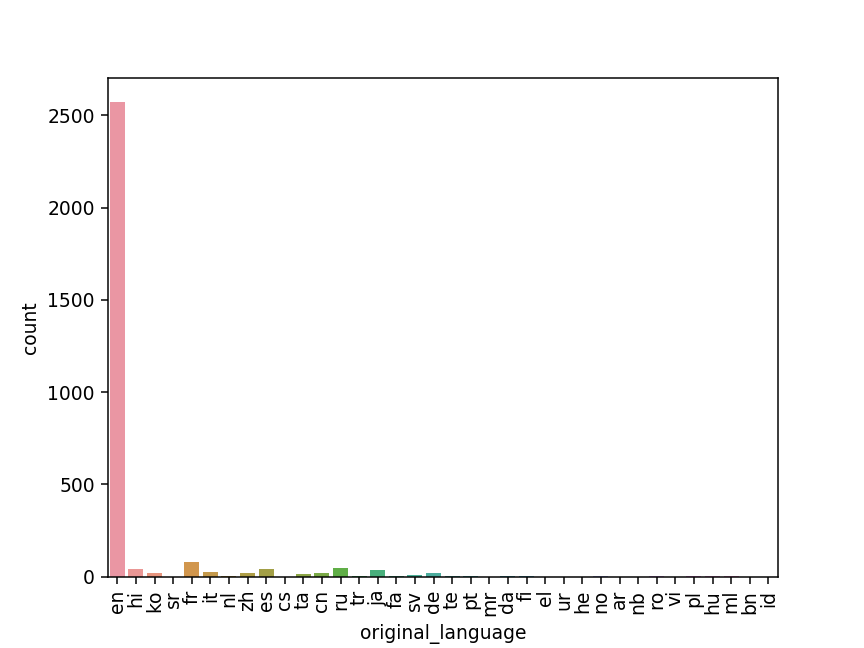

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text xticklabel objects>)

In [36]:
train_data['original_language'][:5]
len(train_data['original_language'].value_counts())
sns.countplot(train_data['original_language'])
plt.xticks(rotation=90)

In [37]:
original_language_list = [i[0] for i in Counter(train_data['original_language']).most_common(15)]

In [38]:
#训练集处理
for i in original_language_list:
    train_data['orginal_language_' + i] = train_data['original_language'].map(lambda x:1 if x==i else 0 )

#测试集处理
for i in original_language_list:
    test_data['orginal_language_' + i] = test_data['original_language'].map(lambda x:1 if x==i else 0 )

In [39]:
#训练集处理
train_data['pr_companies_num'] = train_data['production_companies'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['pr_companies_num'] = test_data['production_companies'].map(lambda x:len(x) if x!={} else 0)

<IPython.core.display.Javascript object>


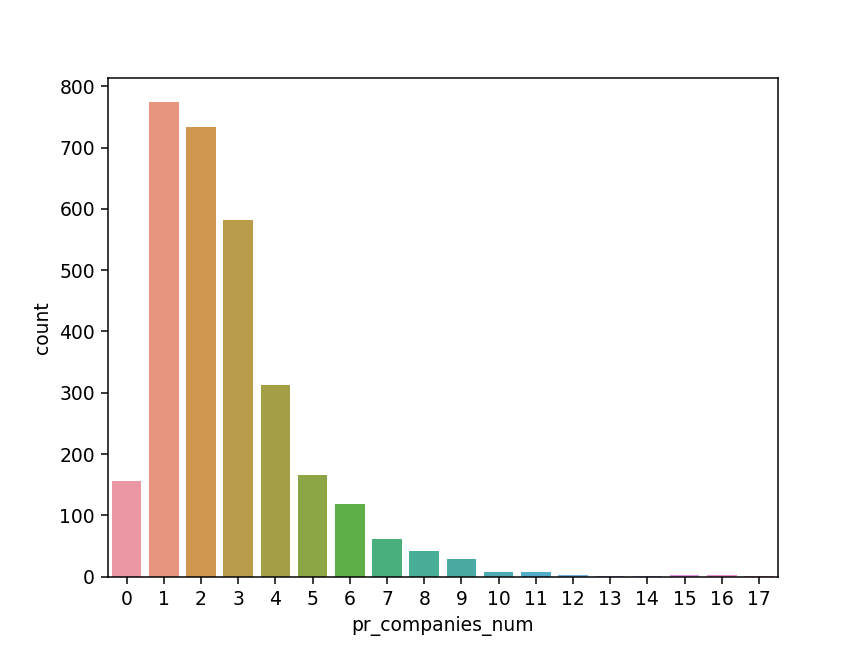

In [40]:
sns.countplot(train_data['pr_companies_num'])

In [41]:
#训练集处理
train_data['companies_all'] = train_data['production_companies'].map(lambda x:','.join([i['name'] for i in x]))

#测试集处理
test_data['companies_all'] = test_data['production_companies'].map(lambda x:','.join([i['name'] for i in x]))

list_companies = list(train_data['production_companies'].map(lambda x:[i['name'] for i in x]))

list_companies_count = []
for i in list_companies:
    for j in i:
        list_companies_count.append(j)
        
companies_top = Counter(list_companies_count).most_common()
len(Counter(list_companies_count))

3695

In [42]:
production_companies_count_list = [i[0] for i in Counter(list_companies_count).most_common(30)]
#训练集处理
for i in production_companies_count_list:
    train_data['companies_' + i] = train_data['companies_all'].map(lambda x:1 if i in x else 0 )

#测试集处理
for i in production_companies_count_list:
    test_data['companies_' + i] = test_data['companies_all'].map(lambda x:1 if i in x else 0 )

In [43]:
#训练集处理
train_data['pr_countries_num'] = train_data['production_countries'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['pr_countries_num'] = test_data['production_countries'].map(lambda x:len(x) if x!={} else 0)

In [44]:
#训练集处理，新增一列，将出品方国家从json中分离出来
train_data['countries_all'] = train_data['production_countries'].map(lambda x:','.join([i['iso_3166_1'] for i in x]))

#测试集处理，新增一列，将出品方国家从json中分离出来
test_data['countries_all'] = test_data['production_countries'].map(lambda x:','.join([i['iso_3166_1'] for i in x]))

train_data['countries_all'][:3]

0    US
1    US
2    US
Name: countries_all, dtype: object

In [45]:
list_countries = list(train_data['production_countries'].map(lambda x:[i['iso_3166_1'] for i in x]))

list_countries_count = []
for i in list_countries:
    for j in i:
        list_countries_count.append(j)

<IPython.core.display.Javascript object>


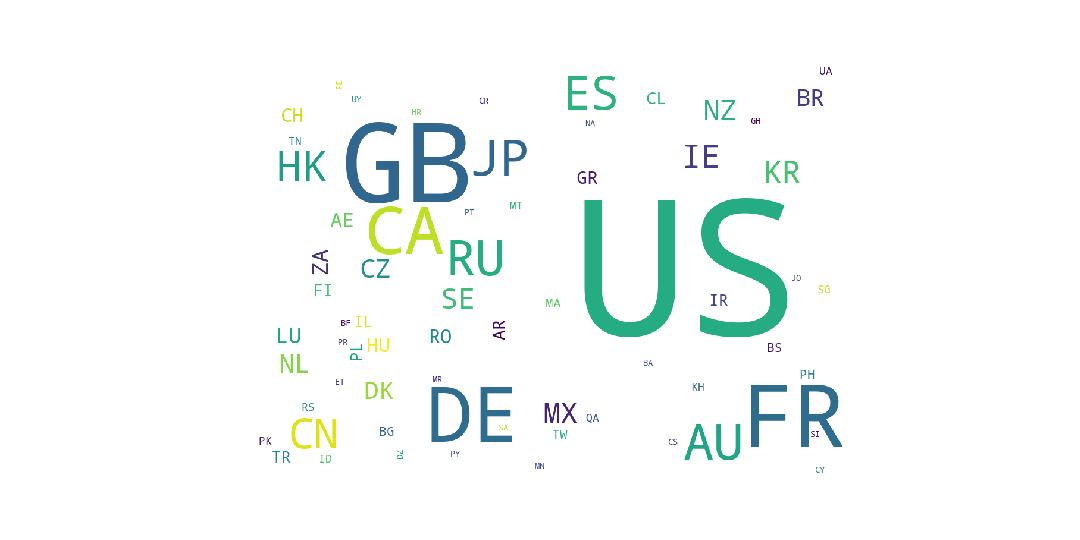

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

In [46]:
fig,ax=plt.subplots(figsize=(8, 4))
w = WordCloud( \
    width = 1000, height = 700,\
    background_color = "white",
    collocations=False
    ).generate(','.join(list_countries_count))
plt.imshow(w)
plt.xticks([])
plt.yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

<IPython.core.display.Javascript object>


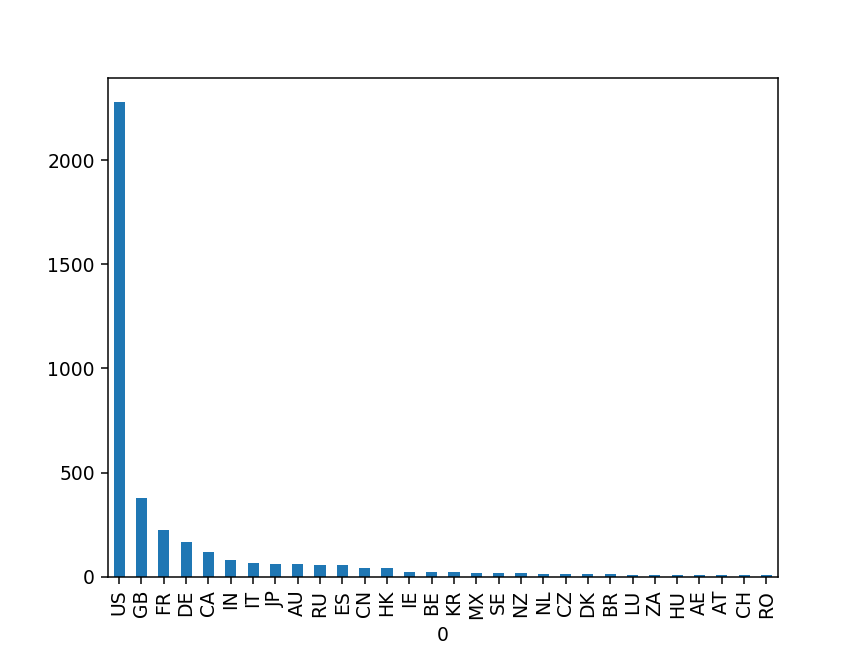

In [47]:
pd.DataFrame(Counter(list_countries_count).most_common(30)).set_index([0]).iloc[:,0].plot(kind='bar')

In [48]:
production_countries_count_list = [i[0] for i in Counter(list_countries_count).most_common(25)]
#训练集处理
for i in production_countries_count_list:
    train_data['pr_countries_' + i] = train_data['countries_all'].map(lambda x:1 if i in x else 0 )

#测试集处理
for i in production_countries_count_list:
    test_data['pr_countries_' + i] = test_data['countries_all'].map(lambda x:1 if i in x else 0 )

In [49]:
def func_one(x):
    if x<=3:
        return 1
    elif x<=6:
        return 2
    elif x<=9:
        return 3
    else:
        return 4
train_data['release_year'] = train_data['release_date'].map(lambda x:parse(x).year)
train_data['release_month'] = train_data['release_date'].map(lambda x:parse(x).month)
train_data['release_day'] = train_data['release_date'].map(lambda x:parse(x).day)
train_data['release_weekday']  = train_data['release_date'].map(lambda x:parse(x).isoweekday())
train_data['release_quarter']  = train_data['release_month'].map(func_one)

In [50]:
test_data.loc[test_data['release_date'].isnull(),'release_date']='1/1/2000'
test_data['release_year'] = test_data['release_date'].map(lambda x:parse(x).year)
test_data['release_month'] = test_data['release_date'].map(lambda x:parse(x).month)
test_data['release_day'] = test_data['release_date'].map(lambda x:parse(x).day)
test_data['release_weekday']  = test_data['release_date'].map(lambda x:parse(x).isoweekday())
test_data['release_quarter']  = test_data['release_month'].map(func_one)

In [51]:
def fun_year(x):
    if x>2019:
        x = x-100
    return x

train_data['release_year'] = train_data['release_year'].map(fun_year)

test_data['release_year'] = test_data['release_year'].map(fun_year)

In [52]:
#训练集处理
train_data['runtime'] = train_data['runtime'].fillna(train_data['runtime'].mode()[0])

#测试集处理
test_data['runtime'] = test_data['runtime'].fillna(test_data['runtime'].mode()[0])

In [53]:
#训练集处理
train_data['spoken_languages_num'] = train_data['spoken_languages'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['spoken_languages_num'] = test_data['spoken_languages'].map(lambda x:len(x) if x!={} else 0)

#训练集处理
train_data['spoken_languages_all'] = train_data['spoken_languages'].map(lambda x:','.join([i['iso_639_1'] for i in x]))

#测试集处理
test_data['spoken_languages_all'] = test_data['spoken_languages'].map(lambda x:','.join([i['iso_639_1'] for i in x]))

list_spoken_languages = list(train_data['spoken_languages'].map(lambda x:[i['iso_639_1'] for i in x]))

list_spoken_languages_count = []
for i in list_spoken_languages:
    for j in i:
        list_spoken_languages_count.append(j)

spoken_languages_count_list = [i[0] for i in Counter(list_spoken_languages_count).most_common(25)]
#训练集处理
for i in spoken_languages_count_list:
    train_data['spoken_languages_' + i] = train_data['spoken_languages_all'].map(lambda x:1 if i in x else 0 )

#测试集处理
for i in spoken_languages_count_list:
    test_data['spoken_languages_' + i] = test_data['spoken_languages_all'].map(lambda x:1 if i in x else 0 )

In [54]:
train_data['has_Released'] = train_data['status'].map(lambda x:1 if x=='Released' else 0)

test_data['has_Released'] = test_data['status'].map(lambda x:1 if x=='Released' else 0)

In [55]:
train_data['has_tagline'] = train_data['tagline'].map(lambda x:0 if pd.isna(x) else 1)

test_data['has_tagline'] = test_data['tagline'].map(lambda x:0 if pd.isna(x) else 1)

In [57]:
#训练集处理
train_data['Keywords_num'] = train_data['Keywords'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['Keywords_num'] = test_data['Keywords'].map(lambda x:len(x) if x!={} else 0)

#训练集处理
train_data['Keywords_all'] = train_data['Keywords'].map(lambda x:','.join([i['name'] for i in x]))

#测试集处理
test_data['Keywords_all'] = test_data['Keywords'].map(lambda x:','.join([i['name'] for i in x]))

list_Keywords = list(train_data['Keywords'].map(lambda x:[i['name'] for i in x]))

list_Keywords_count = []
for i in list_Keywords:
    for j in i:
        list_Keywords_count.append(j)

<IPython.core.display.Javascript object>


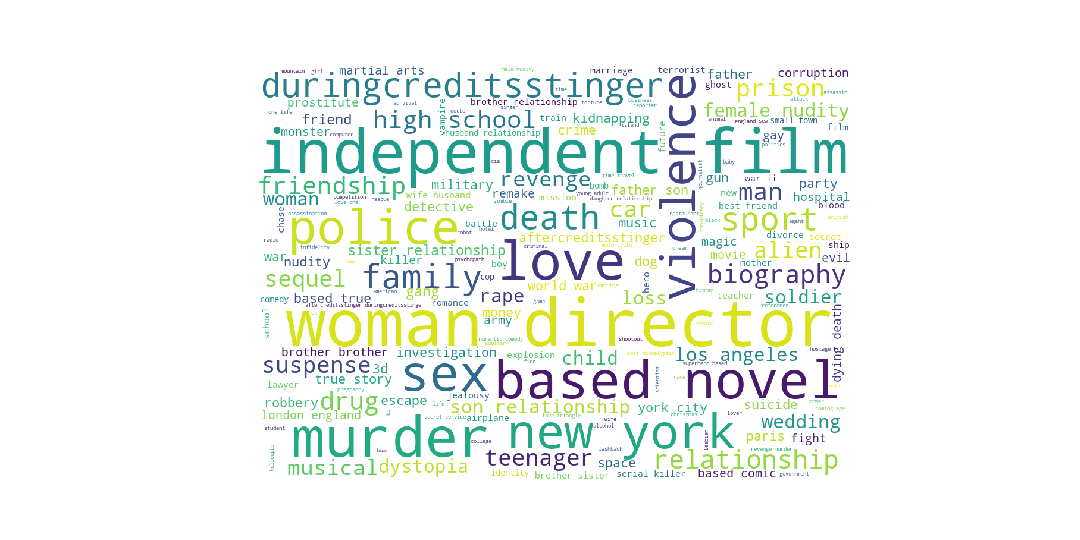

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

In [58]:
fig,ax=plt.subplots(figsize=(8,4))
w = WordCloud( \
    width = 1000, height = 700,
    background_color = "white",
    collocations=True
    ).generate(','.join(list_Keywords_count))
plt.imshow(w)
plt.xticks([])
plt.yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [59]:
list_Keywords_count = [i[0] for i in Counter(list_Keywords_count).most_common(30)]
#训练集处理
for i in list(list_Keywords_count):
    train_data['Keywords_'+i] = train_data['Keywords_all'].map(lambda x:1 if i in x else 0)

#测试集处理
for i in list(list_Keywords_count):
    test_data['Keywords_'+i] = test_data['Keywords_all'].map(lambda x:1 if i in x else 0)

In [60]:
#训练集处理
train_data['cast_num'] = train_data['cast'].map(lambda x:len(x) if x!={} else 0)

#测试集处理
test_data['cast_num'] = test_data['cast'].map(lambda x:len(x) if x!={} else 0)

In [61]:
#训练集处理
train_data['cast_all'] = train_data['cast'].map(lambda x:','.join([i['name'] for i in x]))

#测试集处理
test_data['cast_all'] = test_data['cast'].map(lambda x:','.join([i['name'] for i in x]))

list_cast = list(train_data['cast'].map(lambda x:[i['name'] for i in x]))

list_cast_count = []
for i in list_cast:
    for j in i:
        list_cast_count.append(j)

In [62]:
list_cast_count = [i[0] for i in Counter(list_cast_count).most_common(30)]
for i in list(list_cast_count):
    train_data['cast_'+i] = train_data['cast_all'].map(lambda x:1 if i in x else 0)

for i in list(list_cast_count):
    test_data['cast_'+i] = test_data['cast_all'].map(lambda x:1 if i in x else 0)

In [63]:
train_data['gender_0_Cast'] = train_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train_data['gender_1_Cast'] = train_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train_data['gender_2_Cast'] = train_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

test_data['gender_0_Cast'] = test_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test_data['gender_1_Cast'] = test_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test_data['gender_2_Cast'] = test_data['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

In [64]:
#训练集处理
train_data['crew_all'] = train_data['crew'].map(lambda x:','.join([i['name'] for i in x]))
train_data['crew_department_all'] = train_data['crew'].map(lambda x:','.join([i['department'] for i in x]))

#测试集处理
test_data['crew_all'] = test_data['crew'].map(lambda x:','.join([i['name'] for i in x]))
test_data['crew_department_all'] = test_data['crew'].map(lambda x:','.join([i['department'] for i in x]))

In [65]:
list_crew = list(train_data['crew'].map(lambda x:[i['name'] for i in x]))

list_crew_count = []
for i in list_crew:
    for j in i:
        list_crew_count.append(j)

# crew_top = Counter(list_crew_count).most_common()

list_department = list(train_data['crew'].map(lambda x:[i['department'] for i in x]))

list_department_count = []
for i in list_department:
    for j in i:
        list_department_count.append(j)

# department_top = Counter( list_department_count).most_common()

In [66]:
list_crew_count = [i[0] for i in Counter(list_crew_count).most_common(30)]

list_department_count = [i[0] for i in Counter(list_department_count).most_common()]

for i in list(list_crew_count):
    train_data['crew_'+i] = train_data['crew_all'].map(lambda x:1 if i in x else 0)

for i in list(list_crew_count):
    test_data['crew_'+i] = test_data['crew_all'].map(lambda x:1 if i in x else 0)

for i in list(list_department_count):
    train_data['department_'+i] = train_data['crew_department_all'].map(lambda x:1 if i in x else 0)

for i in list(list_department_count):
    test_data['department_'+i] = test_data['crew_department_all'].map(lambda x:1 if i in x else 0)


In [67]:
train_data['gender_0_crew'] = train_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train_data['gender_1_crew'] = train_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train_data['gender_2_crew'] = train_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

test_data['gender_0_crew'] = test_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test_data['gender_1_crew'] = test_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test_data['gender_2_crew'] = test_data['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

<IPython.core.display.Javascript object>


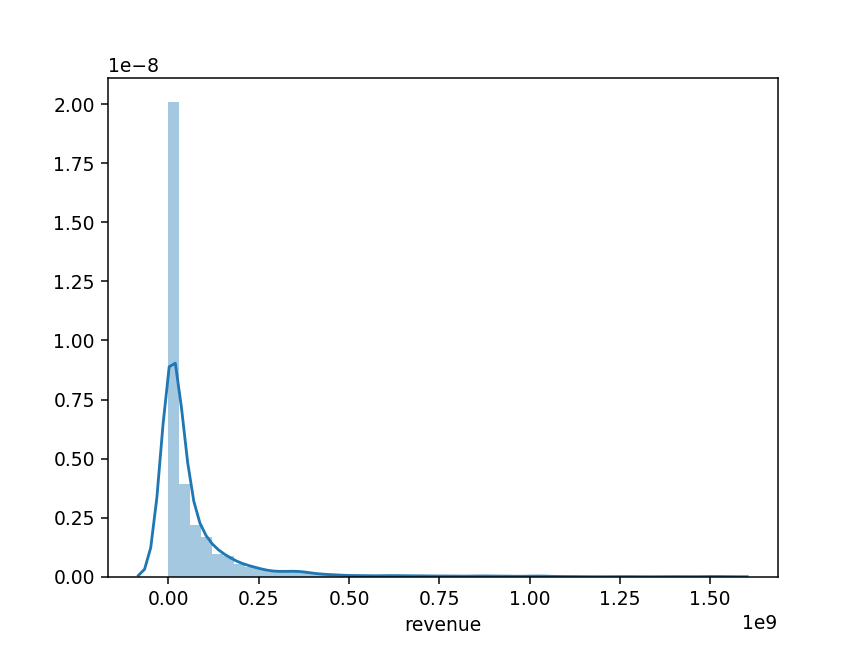

In [68]:
sns.distplot(train_data['revenue'])

<IPython.core.display.Javascript object>


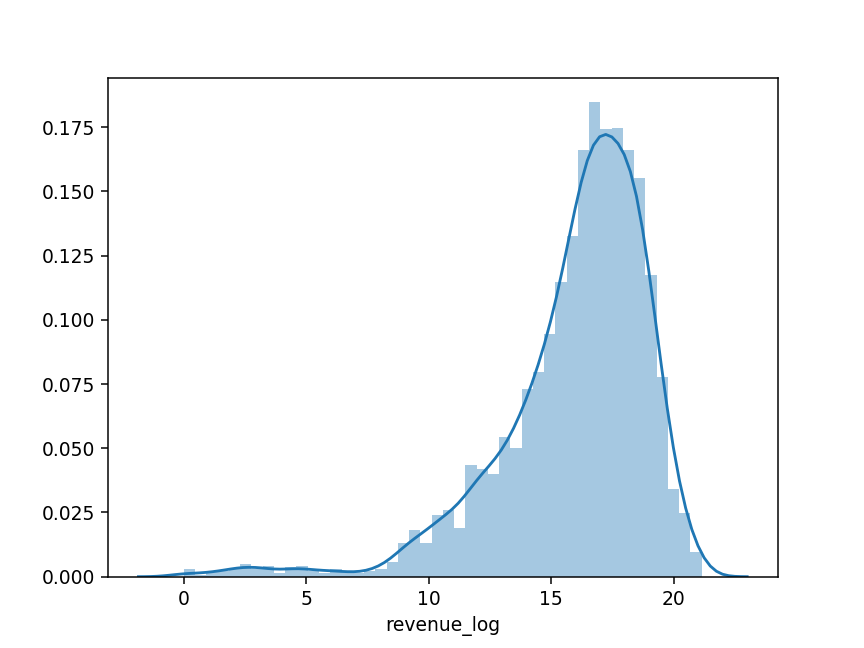

In [69]:
train_data['revenue_log'] = np.log(train_data['revenue'])
sns.distplot(train_data['revenue_log'])

In [70]:
train_data.shape
test_data.shape

(3000, 270)

(4398, 268)

In [75]:
[col for col in train_data.columns if col not in test_data.columns]

['revenue', 'revenue_log']

In [77]:
train_drop_col = ['id','belongs_to_collection','genres','homepage','imdb_id','overview','original_language','original_title',
           'poster_path','production_companies','production_countries','release_date','spoken_languages',
           'status','tagline','title','Keywords','cast','crew','genres_all','companies_all','countries_all','spoken_languages_all',
                'Keywords_all','cast_all','crew_all','crew_department_all','revenue','revenue_log']

test_drop_col = ['id','belongs_to_collection','genres','homepage','imdb_id','overview','original_language','original_title',
           'poster_path','production_companies','production_countries','release_date','spoken_languages',
           'status','tagline','title','Keywords','cast','crew','genres_all','companies_all','countries_all','spoken_languages_all',
                'Keywords_all','cast_all','crew_all','crew_department_all']

In [78]:
X_train_p = train_data.drop(train_drop_col,axis=1)
y_train_p = train_data.loc[:,'revenue_log']

X_test = test_data.drop(test_drop_col,axis=1)

In [79]:
X_train_p.shape
X_test_p.shape

(3000, 241)

(4398, 241)

In [ ]:
def xgb_model(X_train, y_train, X_val, y_val, X_test, verbose):
    params = {'objective': 'reg:linear',
              'eta': 0.01,
              'max_depth': 6,
              'subsample': 0.6,
              'colsample_bytree': 0.7,
              'eval_metric': 'rmse',
              'seed': random_seed,
              'silent': True,
              }

    record = dict()
    model = xgb.train(params
                      , xgb.DMatrix(X_train, y_train)
                      , 100000
                      , [(xgb.DMatrix(X_train, y_train), 'train'),
                         (xgb.DMatrix(X_val, y_val), 'valid')]
                      , verbose_eval=verbose
                      , early_stopping_rounds=500
                      , callbacks=[xgb.callback.record_evaluation(record)])

    best_idx = np.argmin(np.array(record['valid']['rmse']))
    val_pred = model.predict(xgb.DMatrix(X_val), ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)

    return {'val': val_pred, 'test': test_pred, 'error': record['valid']['rmse'][best_idx],
            'importance': [i for k, i in model.get_score().items()]}


def lgb_model(X_train, y_train, X_val, y_val, X_test, verbose):
    params = {'objective': 'regression',
              'num_leaves': 30,
              'min_data_in_leaf': 20,
              'max_depth': 9,
              'learning_rate': 0.004,
              # 'min_child_samples':100,
              'feature_fraction': 0.9,
              "bagging_freq": 1,
              "bagging_fraction": 0.9,
              'lambda_l1': 0.2,
              "bagging_seed": random_seed,
              "metric": 'rmse',
              # 'subsample':.8,
              # 'colsample_bytree':.9,
              "random_state": random_seed,
              "verbosity": -1}

    record = dict()
    model = lgb.train(params
                      , lgb.Dataset(X_train, y_train)
                      , num_boost_round=100000
                      , valid_sets=[lgb.Dataset(X_val, y_val)]
                      , verbose_eval=verbose
                      , early_stopping_rounds=500
                      , callbacks=[lgb.record_evaluation(record)]
                      )
    best_idx = np.argmin(np.array(record['valid_0']['rmse']))

    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)

    return {'val': val_pred, 'test': test_pred, 'error': record['valid_0']['rmse'][best_idx],
            'importance': model.feature_importance('gain')}


def cat_model(X_train, y_train, X_val, y_val, X_test, verbose):
    model = CatBoostRegressor(iterations=100000,
                              learning_rate=0.004,
                              depth=5,
                              eval_metric='RMSE',
                              colsample_bylevel=0.8,
                              random_seed=random_seed,
                              bagging_temperature=0.2,
                              metric_period=None,
                              early_stopping_rounds=200)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=False)

    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    return {'val': val_pred, 'test': test_pred,
            'error': model.get_best_score()['validation_0']['RMSE'],
            'importance': model.get_feature_importance()}


if __name__ == '__main__':
    random_seed = 2019
    k = 10
    fold = list(KFold(k, shuffle=True, random_state=random_seed).split(X_train_p))
    np.random.seed(random_seed)

    result_dict = dict()
    val_pred = np.zeros(X_train_p.shape[0])
    test_pred = np.zeros(X_test.shape[0])
    final_err = 0
    verbose = False

    for i, (train, val) in enumerate(fold):
        print(i + 1, "fold.    RMSE")

        X_train = X_train_p.loc[train, :]
        y_train = y_train_p.loc[train, :].values.ravel()
        X_val = X_train_p.loc[val, :]
        y_val = y_train_p.loc[val, :].values.ravel()

        fold_val_pred = []
        fold_test_pred = []
        fold_err = []

        # """ xgboost
        start = datetime.now()
        result = xgb_model(X_train, y_train, X_val, y_val, X_test, verbose)
        fold_val_pred.append(result['val'] * 0.2)
        fold_test_pred.append(result['test'] * 0.2)
        fold_err.append(result['error'])
        print("xgb model.", "{0:.5f}".format(result['error']),
              '(' + str(int((datetime.now() - start).seconds)) + 's)')
        # """

        # """ lightgbm
        start = datetime.now()
        result = lgb_model(X_train, y_train, X_val, y_val, X_test, verbose)
        fold_val_pred.append(result['val'] * 0.4)
        fold_test_pred.append(result['test'] * 0.4)
        fold_err.append(result['error'])
        print("lgb model.", "{0:.5f}".format(result['error']),
              '(' + str(int((datetime.now() - start).seconds)) + 's)')
        # """

        # """ catboost model
        start = datetime.now()
        result = cat_model(X_train, y_train, X_val, y_val, X_test, verbose)
        fold_val_pred.append(result['val'] * 0.4)
        fold_test_pred.append(result['test'] * 0.4)
        fold_err.append(result['error'])
        print("cat model.", "{0:.5f}".format(result['error']),
              '(' + str(int((datetime.now() - start).seconds)) + 's)')
        # """

        # mix result of multiple models
        val_pred[val] += np.sum(np.array(fold_val_pred), axis=0)
        print(fold_test_pred)
        test_pred += np.sum(np.array(fold_test_pred), axis=0) / k
        final_err += (sum(fold_err) / len(fold_err)) / k

        print("---------------------------")
        print("avg   err.", "{0:.5f}".format(sum(fold_err) / len(fold_err)))
        print("blend err.", "{0:.5f}".format(np.sqrt(np.mean((np.sum(np.array(fold_val_pred), axis=0) - y_val) ** 2))))

        print('')

    print("final avg   err.", final_err)
    print("final blend err.", np.sqrt(np.mean((val_pred - y_train_p.values.ravel()) ** 2)))

    sub = pd.read_csv('./sample_submission.csv')
    df_sub = pd.DataFrame()
    df_sub['id'] = sub['id']
    df_sub['revenue'] = np.expm1(test_pred)
    print(df_sub['revenue'])
    df_sub.to_csv('./submission.csv', index=False)